# **FinSight Evasion Detection Notebook**

## **1. Documentation**

### **1.1 Purpose & Scope**
This notebook implements a pipeline to detect evasive vs direct answers in Q&A transcripts. The primary buisness goal is to maximise recall for the evasive class (minimise false negatives) so reviewers recieve a shortlist of likely evasive answers to inspect. We report ranking metrics such as P@K (precison within the top-K% of predicted positives) to quantify shortlist quality for downstream PRA review. 

Validation and fine-tuning of thresholds was carried out on J.P. Morgan data 2023-2024 Q&A transcript data. J.P. Morgan 2025 and HSBC 2025 Q&A transcript data were used for predictions.

### **1.2 Data & Inputs**
- **Data:** Q&A transcripts (J.P. Morgan 2023-2025 and HSBC 2023-2025). J.P. Morgan used for validation & reporting, HSBC used for reporting.
- **Input format:** A table with the following columns: question_number, answer_number, speaker_name, role, company, content, year, quarter and source_pdf
- **Splits** `train` (used to test exemplar building), `jpm_val_qa_labelled` (for fine tuning thresholds & model selection) and `jpm_test_qa_labelled` (for final reporting). Final predictions were carried out on `jpm_2025_predict_qa` and `hsbc_2025_predict_qa`. 
- **Imbalance:** Strong class imbalance (evasive minority)

### **1.3 Pipeline Overview**
- **Rule-based Baseline:** Flag potential evasions by assessing question-answer semantic similarity, numerical expectations (e.g. question asks for numbers, answer lacks numbers) and evasive phrase hits.
- **NLI-Based Scoring:** Treats each question + answer as the premise and probes entailment against hypotheses representing Direct and Evasive answers using large MNLI models i.e. `roberta-large-mnli`, `microsoft/deberta-large-mnli` and `MoritzLaurer/deberta-v3-large-zeroshot-v2.0`. Map model logits/probabilities to an evasion score. 
- **Few-Shot RAG Exemplars (tested)**: Retrieves a small set of labelled exemplars (via SBERT similarity on question) and prepends them to the NLI context.
- **Blending:** Combines baseline and NLI scores (weighted blend) and averages LLM NLI scores.
- **Thresholding:** Converts scores to binary flags using tuned thresholds. 

### **1.4 Evaluation Metrics**
The notebook reports the following per threshold:
- **Precision/ Recall/ F1** (Direct)
- **Preicsion/ Recall / F1** (Evasive): primary gocus on recall_evasive 
- **AUPRC:** area under precision-recall curve for evasive class 
- **P@K% predicted positives:** e.g. 10%, 25%, 50%, use to set short-list size for flagged evasive answers (number of correctly predicted positives in K% of ranked list)

## **2. Set Up Workspace**

In [ ]:
# Import libraries
# Core python
import os
import numpy as np
import pandas as pd
import re
import json
import pathlib
from pathlib import Path
from typing import List, Dict, Any 
import csv
import math
from collections import OrderedDict

# NLP & Summarisation
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from llama_cpp import Llama 
import torch
import torch.nn.functional as F

# Retrieval
from sentence_transformers import SentenceTransformer 

# ML
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedGroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, average_precision_score
from sklearn.isotonic import IsotonicRegression

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns 

# Set global SEED.
SEED = 42

In [8]:
# Load the dataset.
url = 'https://raw.githubusercontent.com/JSA10/cam_ds_ep_FinSight/refs/heads/main/data/processed/jpm/all_jpm_2023_2025.csv'
all_jpm_2023_2025 = pd.read_csv(url)

# View dataset.
display(all_jpm_2023_2025.head())

# Number of rows.
print('Number of rows:', all_jpm_2023_2025.shape[0])

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
0,presentation,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Thanks, and good morning, everyone. The presen...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
1,qa,NaN,NaN,Steven Chubak,analyst,Wolfe Research LLC,"Hey, good morning.",2023,Q1,True,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
2,qa,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, Steve.",2023,Q1,True,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
3,qa,1.0,NaN,Steven Chubak,analyst,Wolfe Research LLC,"So, Jamie, I was actually hoping to get your p...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
4,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...


Number of rows: 1411


## **3. J.P. Morgan**

### **3.1 Preprocessing**

In [11]:
# Remove pleasantries.
all_jpm_2023_2025_cleaned = all_jpm_2023_2025[all_jpm_2023_2025['is_pleasantry'] == False]
print('Number of rows:', all_jpm_2023_2025_cleaned.shape[0])

Number of rows: 1241


In [12]:
# Check content column.
print('Number of rows with no content:', all_jpm_2023_2025_cleaned['content'].isna().sum())

Number of rows with no content: 23


In [13]:
# Drop rows with no content.
all_jpm_2023_2025_cleaned = all_jpm_2023_2025_cleaned.dropna(subset=['content'])

In [14]:
# Check content column.
print('Number of rows with no content:', all_jpm_2023_2025_cleaned['content'].isna().sum())

Number of rows with no content: 0


In [15]:
# View roles.
all_jpm_2023_2025_cleaned['role'].unique()

array(['Chief Financial Officer', 'analyst',
       'Chairman & Chief Executive Officer',
       'And then some. Theres a lot of value added.', 'Okay',
       "We're fundamentally", 'Thanks', 'Almost no chance.'], dtype=object)

- Some text has leaked into role column and so this was manually corrected.

In [16]:
# View rows with invalid roles. 
valid_roles = 'analyst', 'Chief Financial Officer', 'Chairman & Chief Executive Officer'
invalid_roles_df = all_jpm_2023_2025_cleaned[~all_jpm_2023_2025_cleaned['role'].isin(valid_roles)]
invalid_roles_df.head(10)

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
305,qa,22.0,4.0,"Chief Financial Officer, JPMorganChase",And then some. Theres a lot of value added.,JPMorganChase,"Yeah. And obviously, I mean, we're not going t...",2025,Q2,False,data/raw/jpm/.ipynb_checkpoints/jpm-2q25-earni...
309,qa,23.0,3.0,"Chief Financial Officer, JPMorganChase",Okay,there you have it.,"But it's not like I thought it would do badly,...",2025,Q2,False,data/raw/jpm/.ipynb_checkpoints/jpm-2q25-earni...
650,qa,10.0,3.0,Who knows how important politics are in all th...,We're fundamentally,"as I said, I think on the press call, happy to...",little bit cautious about the pull-forward dyn...,2024,Q1,False,data/raw/jpm/jpm-1q24-earnings-call-transcript...
924,qa,8.0,2.0,"Chief Financial Officer, JPMorgan Chase & Co.",Thanks,Glenn.,"Operator: Next, we'll go to the line of Matt O...",2024,Q2,False,data/raw/jpm/jpm-2q24-earnings-call-transcript...
1059,qa,22.0,4.0,"Chief Financial Officer, JPMorganChase",And then some. Theres a lot of value added.,JPMorganChase,"Yeah. And obviously, I mean, we're not going t...",2025,Q2,False,data/raw/jpm/jpm-2q25-earnings-call-transcript...
1063,qa,23.0,3.0,"Chief Financial Officer, JPMorganChase",Okay,there you have it.,"But it's not like I thought it would do badly,...",2025,Q2,False,data/raw/jpm/jpm-2q25-earnings-call-transcript...
1274,qa,23.0,1.0,"Chairman & Chief Executive Officer, JPMorgan C...",Almost no chance.,JPMorganChase,"Well, but having – it's very important. While ...",2024,Q3,False,data/raw/jpm/jpm-3q24-earnings-conference-call...


In [17]:
# Input the correct role information.
all_jpm_2023_2025_cleaned.loc[[305, 309, 924, 1059, 1063], 'role'] = 'Chief Financial Officer'
all_jpm_2023_2025_cleaned.loc[[1274], 'role'] = 'Chairman & Chief Executive Officer'

# Drop nonsence row.
all_jpm_2023_2025_cleaned = all_jpm_2023_2025_cleaned.drop(index=650)

In [18]:
# Check the roles have been updated.
all_jpm_2023_2025_cleaned['role'].unique()

array(['Chief Financial Officer', 'analyst',
       'Chairman & Chief Executive Officer'], dtype=object)

In [19]:
# Normalise role names.
role_map = {
    'analyst': 'analyst',
    'Chief Financial Officer': 'banker',
    'Chairman & Chief Executive Officer': 'banker'
}

# Map roles.
all_jpm_2023_2025_cleaned['role_normalised'] = all_jpm_2023_2025_cleaned['role'].map(role_map)

In [20]:
# View dataset.
display(all_jpm_2023_2025_cleaned.head())
print('Number of rows:', all_jpm_2023_2025_cleaned.shape[0])

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf,role_normalised
0,presentation,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Thanks, and good morning, everyone. The presen...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...,banker
3,qa,1.0,NaN,Steven Chubak,analyst,Wolfe Research LLC,"So, Jamie, I was actually hoping to get your p...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...,analyst
4,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...,banker
5,qa,1.0,1.0,Steven Chubak,analyst,Wolfe Research LLC,Got it. And just in terms of appetite for the ...,2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...,analyst
6,qa,1.0,2.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Oh, yeah.",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...,banker


Number of rows: 1217


In [21]:
# Save the cleaned dataset.
all_jpm_2023_2025_cleaned.to_csv('../data/processed/jpm/cleaned/all_jpm_2023_2025_cleaned') 

In [ ]:
# Function to remove duplicates within questions and answers. 
def clean_repeats(text):

    # 1) Normalize whitespace
    t = ' '.join(text.split()).strip()
    if not t:
        return t

    # 2) If the whole-string is a back-to-back duplicate (A+A) = keep first half
    mid = len(t) // 2
    if len(t) % 2 == 0 and t[:mid] == t[mid:]:
        t = t[:mid]

    # 3) Collapse immediate repeated token spans (n-grams).
    toks = t.split()
    out = []
    i = 0
    while i < len(toks):
        matched = False
        max_span = min(50, len(toks) - i)  # cap span to remaining length
        for n in range(max_span, 4, -1):  # try longer spans first: 50..5
            if i + 2*n <= len(toks) and toks[i:i+n] == toks[i+n:i+2*n]:
                out.extend(toks[i:i+n])  # keep one copy
                i += 2*n                # skip the duplicate block
                matched = True
                break
        if not matched:
            out.append(toks[i])
            i += 1
    t = ' '.join(out)

    # 4) Remove duplicate sentences globally (order-preserving)
    sents = re.split(r'(?<=[.!?])\s+', t)
    seen = set()
    uniq = []
    for s in sents:
        s_norm = s.strip()
        if not s_norm:
            continue
        key = ' '.join(s_norm.lower().split())
        if key not in seen:
            seen.add(key)
            uniq.append(s_norm)
    return ' '.join(uniq)

In [24]:
# Function to convert datasets into question and answer pairs.
def create_qa_pairs(df, min_answer_words=30):
    
    # Keep only the Q&A section.
    qa_df = df[df['section'].astype(str).str.lower() == 'qa'].copy()

    # Split into roles.
    analyst_rows = qa_df[qa_df['role_normalised'] == 'analyst'].copy()
    banker_rows  = qa_df[qa_df['role_normalised'] == 'banker' ].copy()

    # Keys to keep quarters separated
    key_q = ['year', 'quarter', 'question_number']

    # Build full question text per (year, quarter, question_number)
    question_text_map = (
        analyst_rows
        .groupby(key_q, dropna=False)['content']
        .apply(lambda parts: clean_repeats(' '.join(parts.astype(str))))
        .rename('question')
        .reset_index()
    )

    # Ensure bankers have an answer_number — sequential per (year, quarter, question_number) if missing.
    if 'answer_number' not in banker_rows.columns or banker_rows['answer_number'].isna().any():
        banker_rows = banker_rows.sort_index().copy()
        banker_rows['answer_number'] = (
            banker_rows
            .groupby(key_q, dropna=False)
            .cumcount() + 1
        )

    # Combine multiple banker utterances belonging to the same answer.
    banker_answers = (
        banker_rows
        .groupby(key_q + ['answer_number'], dropna=False)
        .agg({
            'content':        lambda parts: clean_repeats(' '.join(parts.astype(str))),
            'speaker_name':   'first',
            'role':           'first',
            'role_normalised':'first',
            'source_pdf':     'first'
        })
        .rename(columns={'content': 'answer'})
        .reset_index()
    )

    # Merge question text back onto each answer row.
    qa_pairs = banker_answers.merge(
        question_text_map,
        on=key_q,
        how='left',
        validate='many_to_one'
    )

    # Order columns for readability.
    column_order = [
        'year', 'quarter', 'question_number', 'answer_number',
        'question', 'answer',
        'speaker_name', 'role', 'role_normalised',
        'source_pdf'
    ]
    qa_pairs = qa_pairs.reindex(columns=[c for c in column_order if c in qa_pairs.columns])

    # Sort and reset index.
    qa_pairs = qa_pairs.sort_values(['year', 'quarter', 'question_number', 'answer_number']).reset_index(drop=True)

    # Drop duplicate answers.
    qa_pairs = qa_pairs.drop_duplicates(subset=['answer'])

    # Drop short answers below threshold to ensure quality answers.
    qa_pairs = qa_pairs[qa_pairs['answer'].astype(str).str.split().str.len() >= int(min_answer_words)]

    return qa_pairs

In [25]:
# Create q&A pairs.
all_jpm_2023_2025_qa = create_qa_pairs(all_jpm_2023_2025_cleaned)

In [26]:
# View number of examples.
print('Number of examples:', all_jpm_2023_2025_qa.shape[0])

Number of examples: 309


In [27]:
# Split into prediction set and validation/test set.
jpm_2025_predict_qa = all_jpm_2023_2025_qa[all_jpm_2023_2025_qa['year'] == 2025]
jpm_2023_2024_qa = all_jpm_2023_2025_qa[all_jpm_2023_2025_qa['year'].isin([2023, 2024])]

# Save the datasets.
jpm_2025_predict_qa.to_csv('../data/processed/jpm/cleaned/jpm_2025_predict_qa.csv') 
jpm_2023_2024_qa.to_csv('../data/processed/jpm/cleaned/jpm_2023_2024_qa.csv')  

The jpm_2023_2024_qa dataset was then manually labelled according to whether the banker's answer was deemed 'Direct' or 'Evasive'. The label was appended by a new column 'label'.

In [28]:
# Load the labelled dataset.
url = 'https://raw.githubusercontent.com/JSA10/cam_ds_ep_FinSight/refs/heads/main/data/processed/jpm/cleaned/jpm_2023_2024_qa_labelled.csv'
jpm_2023_2024_qa_labelled = pd.read_csv(url)

# View the dataset.
jpm_2023_2024_qa_labelled = jpm_2023_2024_qa_labelled.drop('Unnamed: 0', axis=1)
display(jpm_2023_2024_qa_labelled.head())
print('Number of examples:', jpm_2023_2024_qa_labelled.shape[0])

,year,quarter,question_number,answer_number,question,answer,speaker_name,role,role_normalised,source_pdf,label
0,2023,Q4,1.0,1.0,Good morning. Thanks for all the comments on t...,"Yeah. Matt, not particularly updating. I think...",Jeremy Barnum,Chief Financial Officer,banker,data/raw/jpm/jpm-4q23-earnings-call-transcript...,Direct
1,2023,Q4,2.0,1.0,"Okay. And then just separately, you bought bac...",Yeah. Good question. And I think you framed it...,Jeremy Barnum,Chief Financial Officer,banker,data/raw/jpm/jpm-4q23-earnings-call-transcript...,Direct
2,2023,Q4,3.0,1.0,"Thanks. Jeremy, could you give a little more c...","Yeah. Actually, John, this quarter, that's all...",Jeremy Barnum,Chief Financial Officer,banker,data/raw/jpm/jpm-4q23-earnings-call-transcript...,Direct
3,2023,Q4,4.0,1.0,"Okay. And then, just to follow up on the NII, ...","Sure. Yeah, happy to do that, John. So, I thin...",Jeremy Barnum,Chief Financial Officer,banker,data/raw/jpm/jpm-4q23-earnings-call-transcript...,Direct
4,2023,Q4,5.0,1.0,Hey. Good morning. Maybe just to follow up in ...,Yeah. Both good questions. So let's do reprice...,Jeremy Barnum,Chief Financial Officer,banker,data/raw/jpm/jpm-4q23-earnings-call-transcript...,Direct


Number of examples: 215


In [29]:
# Function to split datasets while keeping answers for the same question grouped.
def stratified_group_split(df, group_key, label_col='label', test_size=0.5, random_state=SEED):

    y = (df[label_col].astype(str).str.strip().str.lower() == 'evasive').astype(int).values
    groups = df[group_key].values
    X_dummy = np.zeros(len(df))  # required placeholder

    # Choose k so one fold approximates to test size.
    n_splits = max(2, int(round(1.0 / float(test_size))))
    sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    best = None
    best_gap = None
    for tr_idx, te_idx in sgkf.split(X_dummy, y, groups):
        prop = len(te_idx) / len(df)
        gap = abs(prop - test_size)
        if best is None or gap < best_gap:
            best = (tr_idx, te_idx)
            best_gap = gap

    train_idx, test_idx = best

    # Name the held-out fold val, keep the rest as test.
    val_df  = df.iloc[test_idx].reset_index(drop=True)
    test_df = df.iloc[train_idx].reset_index(drop=True)
    return val_df, test_df

In [30]:
# Make a group key so that all answers for the same question stay in the same set. 
jpm_2023_2024_qa_labelled['group_key'] = (
    jpm_2023_2024_qa_labelled['year'].astype(str) + '_' +
    jpm_2023_2024_qa_labelled['quarter'].astype(str) + '_' +
    jpm_2023_2024_qa_labelled['question_number'].astype(str)
)

In [33]:
# Split into validation and test set.
jpm_val_qa_labelled, jpm_test_qa_labelled = stratified_group_split(
    jpm_2023_2024_qa_labelled,
    group_key='group_key',
    label_col='label'
)

print(f'Number of validation examples: {jpm_val_qa_labelled.shape[0]} \n{jpm_val_qa_labelled["label"].value_counts()}')
print(f'Number of test examples: {jpm_test_qa_labelled.shape[0]} \n{jpm_test_qa_labelled["label"].value_counts()}')

Number of validation examples: 104 
label
Direct     78
Evasive    26
Name: count, dtype: int64
Number of test examples: 111 
label
Direct     95
Evasive    16
Name: count, dtype: int64


In [34]:
# Save the datasets.
jpm_val_qa_labelled.to_csv('../data/processed/jpm/cleaned/jpm_val_qa_labelled.csv')
jpm_test_qa_labelled.to_csv('../data/processed/jpm/cleaned/jpm_test_qa_labelled.csv')

### **3.2 Baseline Set Up**

In [ ]:
# List of evasive phrases
EVASIVE_PHRASES = [
    r"\btoo early\b",
    r"\bcan't (?:comment|share|discuss)\b",
    r"\bwon't (?:comment|share|provide)\b",
    r"\bno (?:update|comment)\b",
    r"\bwe (?:don't|do not) (?:break out|provide guidance)\b",
    r"\bnot (?:going to|able to) (?:comment|share|provide)\b",
    r"\bwe'll (?:come back|circle back)\b",
    r"\bnot something we disclose\b",
    r"\bas (?:we|I) (?:said|mentioned)\b",
    r"\bgenerally speaking\b",
    r"\bit's premature\b",
    r"\bit's difficult to say\b",
    r"\bI (?:wouldn't|won't) want to (?:speculate|get into)\b",
    r"\bI (?:think|guess|suppose)\b",
    r"\bkind of\b",
    r"\bsort of\b",
    r"\baround\b",
    r"\broughly\b",
    r"\bwe (?:prefer|plan) not to\b",
    r"\bwe're not prepared to\b",
]

# List of words that suggest the answer needs specific financial numbers to properly answer the question.
SPECIFICITY_TRIGGERS = [
    "how much","how many","what is","what are","when","which","where","who","why",
    "range","guidance","margin","capex","opex","revenue","sales","eps","ebitda",
    "timeline","date","target","growth","update","split","dividend","cost","price",
    "units","volumes","gross","net","tax","percentage","utilization","order book"
]

NUMERIC_PATTERN = r"(?:\d+(?:\.\d+)?%|\b\d{1,3}(?:,\d{3})*(?:\.\d+)?\b|£|\$|€)"

In [ ]:
# Function for semantic similarity.
_sbert = SentenceTransformer('all-MiniLM-L6-v2')
def semantic_sim(q, a):
    qv, av = _sbert.encode([q, a], normalize_embeddings=True)
    return float(np.dot(qv, av))

In [ ]:
# Function to compute baseline evasion score.
def baseline_evasion_score(q, a):
    # 1. Semantic similarity
    sim = semantic_sim(q, a) # calculates semantic similarity using previous function
    sim_component = (1 - sim) * 45 # less similar the answer is, the bigger the contribution to the evasion score, scaled by 45

    # 2. Numerical specificity- Does the question require and answer with financial figures/ a specific answer?
    needs_num = any(t in q.lower() for t in SPECIFICITY_TRIGGERS) # true if the question requires a numeric/ specific answer
    has_num = bool(re.search(NUMERIC_PATTERN, a)) # true if the answer includes a number 
    numeric_component = 25 if needs_num and not has_num else 0 # score of 25 if the question needs a number but the answer doesn't give one

    # 3. Evasive phrases- does the answer contain evasive phrases?
    phrase_hits = sum(len(re.findall(p, a.lower())) for p in EVASIVE_PHRASES) # counts how many times an evasive phrase appears in the answer
    phrase_component = min(3, phrase_hits) * 8 # max of 3 hits counted, each hit = 8 points 

    # Final evasion score.
    score = min(100, sim_component + numeric_component + phrase_component) # adds components together and caps score at 100
    
    return score, sim, phrase_hits, needs_num, has_num

### **3.3 LLM Model Set Up**

In [ ]:
# Model name checkpoints.
roberta_name = 'roberta-large-mnli'
deberta_name = 'microsoft/deberta-large-mnli'
zs_deberta_name = 'MoritzLaurer/deberta-v3-large-zeroshot-v2.0'

# Load tokenizers and models.
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_name)
roberta = AutoModelForSequenceClassification.from_pretrained(roberta_name)

deberta_tokenizer = AutoTokenizer.from_pretrained(deberta_name)
deberta = AutoModelForSequenceClassification.from_pretrained(deberta_name)

zs_deberta_tokenizer = AutoTokenizer.from_pretrained(zs_deberta_name)
zs_deberta = AutoModelForSequenceClassification.from_pretrained(zs_deberta_name)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. ini

In [ ]:
# Verify label order per model.
print("roberta id2label:", roberta.config.id2label)
print("deberta id2label:", deberta.config.id2label)
print("zs_deberta id2label:", zs_deberta.config.id2label)

roberta id2label: {0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}
deberta id2label: {0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}
zs_deberta id2label: {0: 'entailment', 1: 'not_entailment'}


- Roberta and deberta have the standard 3 MNLI labels whereas zero shot deberta is binary.

In [ ]:
# Add models and tokenizers to dictionary.
models_and_tokenizers = {
        'roberta': (roberta, roberta_tokenizer),
        'deberta': (deberta, deberta_tokenizer),
        'zs_deberta': (zs_deberta, zs_deberta_tokenizer)
        }

In [ ]:
# Set device 
USE_MPS = True

if USE_MPS:
    device = torch.device('mps')
    DTYPE = torch.float32
else:
    device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    DTYPE = torch.float16 if device.type == "cuda" else torch.float32

for model, tok in models_and_tokenizers.values():
    model.to(device, dtype=DTYPE).eval()

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [ ]:
# Function to build the premise for the model (question + answer).
def build_premise(q, a):
    return f'[QUESTION] {q} [ANSWER] {a}'

The following functions are helper functions for handling long Q/A text pairs by:
- Figuring out out how much text fits
- Splitting the answer into chunks
- Encoding question + answer pairs, handling overflow
- Retrieving the correct output label indices

In [ ]:
# Function to get the max sequence length for the model.
def model_max_len(tokenizer, model):
    m = getattr(tokenizer, "model_max_length", None) # try to get max length from tokenizer 
    if m is None or m == int(1e30):
        m = getattr(getattr(model, "config", None), "max_position_embeddings", 512) # default to 512 if not found
    return int(m or 512)

# Function to count how many tokens a text will take.
def token_len(tokenizer, text):
    return len(tokenizer.encode(text, add_special_tokens=False))

# Function to calculate how much room is left for the answer in a Q/A pair
def compute_answer_budget(tokenizer, model, question, hyp_max_tokens, q_cap=128, safety_margin=12):
    max_len = model_max_len(tokenizer, model)           
    specials = tokenizer.num_special_tokens_to_add(pair=True)
    q_tokens = min(token_len(tokenizer, question), q_cap)
    budget = max_len - specials - q_tokens - hyp_max_tokens - safety_margin
    return max(32, budget) # ensure at least 32 tokens.

# Function to split long answers into overlapping chunks that fit into the token budget.
def chunk_answer_for_pair(tokenizer, answer, answer_budget, stride_tokens=128):

    toks = tokenizer.tokenize(answer) # break answer into tokens.
    if len(toks) <= answer_budget:
        return [answer] # return as a single chunk if the answer fits inside the budget.

    chunks, i = [], 0 # split long answers into overlapping chunks 
    while i < len(toks):
        window_tokens = toks[i:i+answer_budget]
        window_text = tokenizer.convert_tokens_to_string(window_tokens)
        chunks.append(window_text)
        if i + answer_budget >= len(toks):
            break
        i += max(1, answer_budget - stride_tokens)
    return chunks

In [ ]:
# Function to encode premise and hypothesis, handle overflow by chunking, run through model and return logits for each chunk.
def pair_logits_chunks(model, tokenizer, device, premise, hypothesis, max_length=None, stride=128):
    if max_length is None:
        max_length = model_max_len(tokenizer, model)

    # Encode Q/A pairs into tensors.
    enc = tokenizer(
        premise,
        hypothesis,
        return_tensors='pt',
        truncation='only_first',          
        max_length=max_length,
        stride=stride,
        return_overflowing_tokens=True,
        padding=True             
    )

    # keep only keys the model expects
    input_names = set(getattr(tokenizer, "model_input_names",
                              ["input_ids", "attention_mask", "token_type_ids"]))

    # Extract one encoded chunk into a batch the model can handle and move it to device 
    def to_batch(enc_dict, i=None):
        batch = {}
        for k, v in enc_dict.items():
            if k in input_names and isinstance(v, torch.Tensor):
                batch[k] = (v[i:i+1] if i is not None else v).to(device)
        return batch

    # if there is only a single chunk, run model + return logits.
    if enc["input_ids"].shape[0] == 1:
        batch = to_batch(enc)
        with torch.no_grad():
            logits = model(**batch).logits
        return [logits.squeeze(0)]

    # if there are multiple overflowed chunks, loop over each chunk, get logits and return list 
    logits_list = []
    n = enc["input_ids"].shape[0]
    for i in range(n):
        batch = to_batch(enc, i)
        with torch.no_grad():
            out = model(**batch).logits
        logits_list.append(out.squeeze(0))
    return logits_list

In [ ]:
# Function to get the label index for a given class name.
def get_label_idx(model, name, default):
    id2label = getattr(model.config, "id2label", {}) # get model mapping from class IDs to labels 
    if id2label:
        for k, v in id2label.items():
            if name in str(v).lower():
                return int(k)
    return default # return to default if not found 

In [ ]:
# Function to turn raw model outputs into a probability of entailment. 
def p_entail_from_logits(logits, model, temperature=None):

    if temperature is not None and float(temperature) != 1.0:
        logits = logits / float(temperature)

    ent_i = get_label_idx(model, "entail", 2 if logits.shape[-1]==3 else 1) # if 3 classes = assume index 2, if binary = assume index 1
    probs = torch.softmax(logits, dim=-1) # convert logits into probabilities using softmax.
    return float(probs[ent_i])


# Direct and evasive prompts.
DIRECT_TEMPLATES = [
    "The answer gives a direct and specific response to the question.",
    "The answer addresses the question explicitly and concretely.",
    "The answer responds directly with actionable specifics.",
    "The answer provides the requested figures.", 
    "The answer is specific and on-topic."
]
EVASIVE_TEMPLATES = [
    "The answer avoids giving a direct response to the question.",
    "The answer is evasive or deflects without specifics.",
    "The answer sidesteps the question and withholds details.",
    "The answer avoids specifics or deflects.", 
    "The answer does not address the question."
]

In [ ]:
# Function to produce normalised probabilities for direct vs evasive 
def llm_evasion_score(question, answer, model, tokenizer, device, temperature=2.0, stride=128):
    max_len = model_max_len(tokenizer, model)
    n_dir, n_eva = len(DIRECT_TEMPLATES), len(EVASIVE_TEMPLATES)

    p_ent_direct_list, p_ent_evasive_list = [], []

    premise = f"Q: {question}\nA: {answer}"

    def agg_pents(pents, k=1):
    # Take average of top-k highest probs
        return float(np.mean(sorted(pents, reverse=True)[:k]))

    # Collect P(entailment) for DIRECT hypotheses (over chunks), then mean over templates
    for h in DIRECT_TEMPLATES:
        logits_chunks = pair_logits_chunks(model, tokenizer, device, premise, h, max_length=max_len, stride=stride)
        # For each chunk, compute P(entail); take the max across chunks 
        pents = [p_entail_from_logits(log, model, temperature) for log in logits_chunks]
        p_ent_direct_list.append(agg_pents(pents, k=2))

    # Same for EVASIVE hypotheses
    for h in EVASIVE_TEMPLATES:
        logits_chunks = pair_logits_chunks(model, tokenizer, device, premise, h, max_length=max_len, stride=stride)
        pents = [p_entail_from_logits(log, model, temperature) for log in logits_chunks]
        p_ent_evasive_list.append(agg_pents(pents, k=2))

    # Mean over templates
    p_ent_direct  = float(torch.tensor(p_ent_direct_list).mean())
    p_ent_evasive = float(torch.tensor(p_ent_evasive_list).mean())

    # Normalisation
    denom = p_ent_evasive + p_ent_direct + 1e-9
    p_evasive = float(p_ent_evasive / denom)
    p_direct  = 1.0 - p_evasive

    return {
        'p_direct': p_direct,
        'p_evasive': p_evasive,
        'p_ent_direct': p_ent_direct,
        'p_ent_evasive': p_ent_evasive
    }

### **3.4 Proof Of Concept**

To verify that the evasion scoring of the baseline and LLMs was logical at a basic level and the models behave as expected, the models were fed two simple prompts that were clearly direct or evasive, to which each model generated a probability of evasiveness (raw evasion score). This was also to check that the scoring system had been set-up correctly, i.e high evasion score = high probability of evasiveness.

In [ ]:
# --- Probe: DeBERTa, Blended (baseline + DeBERTa), and Avg LLM ---
def probe_deberta_blend_avg(LLM_WEIGHT=0.70):
    pairs = [
        ("What was CET1 at year-end?", "CET1 ratio was 13.4%, up 40bps YoY."),  # DIRECT
        ("When will you release site losses?", "We don’t provide those numbers at this time.")  # EVASIVE
    ]

    # Make sure we can access DeBERTa from your dict
    m_deb, t_deb = models_and_tokenizers["deberta"]

    for i, (q, a) in enumerate(pairs, 1):
        # --- DeBERTa ---
        r_deb = llm_evasion_score(q, a, m_deb, t_deb, device)
        p_eva_deb = float(r_deb["p_evasive"])  # 0..1

        # --- Avg LLM over all models you loaded ---
        all_ps = []
        for mname, (m, t) in models_and_tokenizers.items():
            r = llm_evasion_score(q, a, m, t, device)
            all_ps.append(float(r["p_evasive"]))
        p_eva_avg = float(np.mean(all_ps))

        # --- Baseline (0..100) then blend with DeBERTa using LLM_WEIGHT ---
        base_score, *_ = baseline_evasion_score(q, a)   # 0..100
        base01 = base_score / 100.0
        p_eva_blended = (1.0 - LLM_WEIGHT) * base01 + LLM_WEIGHT * p_eva_deb

        print(f"\n=== Probe {i} ===")
        print(f"Q: {q}\nA: {a}")
        print(f"DeBERTa evasive probabilitiy:                {p_eva_deb*100:.1f} %")
        print(f"Avg LLM evasive probabilitiy:                {p_eva_avg*100:.1f} %")
        print(f"Baseline evasive probabilitiy:               {base_score:.1f} %")
        print(f"Blended (base+DeBERTa) evasive probabilitiy: {p_eva_blended*100:.1f} % "
              f"[LLM_WEIGHT={LLM_WEIGHT:.2f}]")

# Run it
probe_deberta_blend_avg(LLM_WEIGHT=LLM_WEIGHT)


=== Probe 1 ===
Q: What was CET1 at year-end?
A: CET1 ratio was 13.4%, up 40bps YoY.
DeBERTa evasive probabilitiy:                40.7 %
Avg LLM evasive probabilitiy:                21.2 %
Baseline evasive probabilitiy:               23.1 %
Blended (base+DeBERTa) evasive probabilitiy: 34.1 % [LLM_WEIGHT=0.62]

=== Probe 2 ===
Q: When will you release site losses?
A: We don’t provide those numbers at this time.
DeBERTa evasive probabilitiy:                72.6 %
Avg LLM evasive probabilitiy:                78.1 %
Baseline evasive probabilitiy:               59.1 %
Blended (base+DeBERTa) evasive probabilitiy: 67.6 % [LLM_WEIGHT=0.62]


**Proof of Concept Results**
- **Probe 1:** All models leaned towards direct (low evasive probability) which is correct, with the avg_llm giving the lowest probability (21.2%).
- **Probe 2:** All models assigned high evasive probabilities, correctly flagging it as evasive. Again the avg_llm gave the most extreme correct score, assigning the highest probability (78.1%).
- **Overall:** This demonstrates the pipeline behaves as intended when faced with basic QA pairs.  

### **3.5 Generate Evasion Scores**

Evasion scores were generated on the J.P. Morgan validation dataset. 

In [ ]:
# Function to generate evasion scores for baseline + LLMs.
def evasion_pipeline_val(df, models_and_tokenizers, device, LLM_WEIGHT):
    rows = []
    for _, row in df.iterrows():
        q, a = str(row['question']), str(row['answer'])

        # baseline (raw 0..100 float)
        base_score, *_ = baseline_evasion_score(q, a)

        rec = {
            'question_number': row.get('question_number'),
            'question': q,
            'answer': a,
            'evasion_score_baseline': float(base_score),
            'label': row['label'],  # keep human label
        }

        llm_scores = {}
        for name, (m, t) in models_and_tokenizers.items():
            r = llm_evasion_score(q, a, m, t, device)
            s = float(100.0 * r['p_evasive'])
            rec[f'evasion_score_{name}'] = s
            llm_scores[name] = s

        llm_avg = float(np.mean(list(llm_scores.values()))) if llm_scores else 0.0
        rec['evasion_score_llm_avg'] = llm_avg
        rec['evasion_score_blended'] = float(np.clip((1.0 - LLM_WEIGHT)*base_score + LLM_WEIGHT*llm_avg, 0.0, 100.0))

        rows.append(rec)

    return pd.DataFrame(rows)

In [ ]:
# Perform an initial run to get evasion scores on validation set. 
LLM_WEIGHT = 0.70

jpm_val_qa_scores = evasion_pipeline_val(
    jpm_val_qa_labelled, 
    models_and_tokenizers, 
    device, 
    LLM_WEIGHT
    )

In [ ]:
# View the results.
jpm_val_qa_scores.head()

,question_number,question,answer,evasion_score_baseline,label,evasion_score_roberta,evasion_score_deberta,evasion_score_zs_deberta,evasion_score_llm_avg,evasion_score_blended
0,1.0,Good morning. Thanks for all the comments on t...,"Yeah. Matt, not particularly updating. I think...",30.251499,Direct,41.009685,71.487081,80.011915,64.169560,53.994142
1,4.0,"Okay. And then, just to follow up on the NII, ...","Sure. Yeah, happy to do that, John. So, I thin...",36.422580,Direct,24.478366,42.467039,26.846263,31.263889,32.811496
2,5.0,Hey. Good morning. Maybe just to follow up in ...,Yeah. Both good questions. So let's do reprice...,60.731791,Direct,41.489162,46.582340,15.742660,34.604720,42.442842
3,6.0,Hey. Good morning. I guess maybe one question ...,"Right. Okay, Ebrahim. So, I think a lot of tho...",43.920715,Direct,51.206240,62.483139,54.168614,55.952665,52.343080
4,6.0,Hey. Good morning. I guess maybe one question ...,"So, one can speculate about different trajecto...",50.257613,Evasive,39.608096,69.655925,66.430823,58.564948,56.072747


### **3.6 Fine-Tune Thresholds**

In [ ]:
# Function to extract ground truth (1 = Evasive, 0 = Direct)
def extract_y_true(df):
    return (df['label'].astype(str).str.strip().str.lower() == 'evasive').astype(int).values

In [ ]:
# Function to tune the threshold on raw evasion scores per model.
def threshold_tuner(df, score_col, thr_grid, k_percents=(10, 25, 50)):
    y_true = extract_y_true(df)                     # get true labels
    scores = df[score_col].astype(float).values     # get raw evasion scores 

    n = len(scores)  # <-- define n BEFORE using it
    k_take = {k: max(1, int(np.ceil(n * k / 100))) for k in k_percents}

    rows = []
    for thr in thr_grid:
        y_pred = (scores >= thr).astype(int) # label response evasive (1) if score is higher than threshold

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)

        prec_cls, rec_cls, f1_cls, sup_cls = precision_recall_fscore_support(
            y_true, y_pred, labels=[0,1], average=None, zero_division=0
        )

        predpos_idx = np.where(y_pred == 1)[0]
        p_at_predpos = {}
        if len(predpos_idx) > 0:
            predpos_sorted = predpos_idx[np.argsort(-scores[predpos_idx])]
            for k in k_percents:
                k_pp = min(len(predpos_sorted), k_take[k])  # cap by pool size
                if k_pp > 0:
                    take = predpos_sorted[:k_pp]
                    p_at_predpos[f"P@{k}%_predpos"] = float(y_true[take].mean())
                else:
                    p_at_predpos[f"P@{k}%_predpos"] = 0.0
        else:
            for k in k_percents:
                p_at_predpos[f"P@{k}%_predpos"] = 0.0

        rows.append({
            'threshold': float(thr),
            #'precision': precision,
            #'recall': recall,
            #'f1': f1,
            #'accuracy': accuracy,
            #'f1_macro':  (f1_cls[0] + f1_cls[1]) / 2.0,
            'precision_direct':  prec_cls[0],
            'recall_direct':     rec_cls[0],
            'f1_direct':         f1_cls[0],

            'precision_evasive': prec_cls[1],
            'recall_evasive':    rec_cls[1],
            'f1_evasive':        f1_cls[1],
            **p_at_predpos
        })
    results = pd.DataFrame(rows).sort_values(
        by=['f1_evasive', 'recall_evasive'],
        ascending=[False, False]
        ).reset_index(drop=True)
    
    return results

In [ ]:
# Define thr_grid.
thr_grid = np.arange(1, 100, 1)

In [ ]:
# Baseline / blended / avg LLM 
base_results = threshold_tuner(jpm_val_qa_scores, 'evasion_score_baseline', thr_grid)
llm_avg_results = threshold_tuner(jpm_val_qa_scores, 'evasion_score_llm_avg', thr_grid)
blend_results = threshold_tuner(jpm_val_qa_scores, 'evasion_score_blended', thr_grid)

# Individual LLM models
roberta_results = threshold_tuner(jpm_val_qa_scores, 'evasion_score_roberta', thr_grid)
deberta_results = threshold_tuner(jpm_val_qa_scores, 'evasion_score_deberta', thr_grid)
zs_deberta_results = threshold_tuner(jpm_val_qa_scores, 'evasion_score_zs_deberta', thr_grid)

In [ ]:
# View top 5 configurations for each model.
print('\nBaseline — Top 5')
display(base_results.head(5))
print('\nLLM Avg — Top 5') 
display(llm_avg_results.head(5))
print('\nBlended — Top 5')
display(blend_results.head(5))
print('\nRoBERTa — Top 5') 
display(roberta_results.head(5))
print('\nDeBERTa — Top 5')
display(deberta_results.head(5))
print('\nZS-DeBERTa — Top 5')
display(zs_deberta_results.head(5))


Baseline — Top 5


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos
0,22.0,0.875000,0.089744,0.162791,0.260417,0.961538,0.409836,0.272727,0.269231,0.230769
1,20.0,0.833333,0.064103,0.119048,0.255102,0.961538,0.403226,0.272727,0.269231,0.230769
2,21.0,0.833333,0.064103,0.119048,0.255102,0.961538,0.403226,0.272727,0.269231,0.230769
3,1.0,0.000000,0.000000,0.000000,0.250000,1.000000,0.400000,0.272727,0.269231,0.230769
4,2.0,0.000000,0.000000,0.000000,0.250000,1.000000,0.400000,0.272727,0.269231,0.230769



LLM Avg — Top 5


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos
0,33.0,1.000000,0.128205,0.227273,0.276596,1.000000,0.433333,0.363636,0.230769,0.25
1,46.0,0.837838,0.397436,0.539130,0.298507,0.769231,0.430108,0.363636,0.230769,0.25
2,32.0,1.000000,0.089744,0.164706,0.268041,1.000000,0.422764,0.363636,0.230769,0.25
3,47.0,0.825000,0.423077,0.559322,0.296875,0.730769,0.422222,0.363636,0.230769,0.25
4,31.0,1.000000,0.076923,0.142857,0.265306,1.000000,0.419355,0.363636,0.230769,0.25



Blended — Top 5


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos
0,41.0,0.863636,0.243590,0.380000,0.280488,0.884615,0.425926,0.272727,0.269231,0.25
1,42.0,0.840000,0.269231,0.407767,0.278481,0.846154,0.419048,0.272727,0.269231,0.25
2,35.0,0.900000,0.115385,0.204545,0.265957,0.961538,0.416667,0.272727,0.269231,0.25
3,36.0,0.900000,0.115385,0.204545,0.265957,0.961538,0.416667,0.272727,0.269231,0.25
4,34.0,0.888889,0.102564,0.183908,0.263158,0.961538,0.413223,0.272727,0.269231,0.25



RoBERTa — Top 5


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos
0,28.0,0.916667,0.141026,0.244444,0.271739,0.961538,0.423729,0.454545,0.230769,0.25
1,27.0,0.909091,0.128205,0.224719,0.268817,0.961538,0.420168,0.454545,0.230769,0.25
2,25.0,1.000000,0.076923,0.142857,0.265306,1.000000,0.419355,0.454545,0.230769,0.25
3,26.0,0.900000,0.115385,0.204545,0.265957,0.961538,0.416667,0.454545,0.230769,0.25
4,18.0,1.000000,0.051282,0.097561,0.260000,1.000000,0.412698,0.454545,0.230769,0.25



DeBERTa — Top 5


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos
0,56.0,0.813953,0.448718,0.578512,0.295082,0.692308,0.413793,0.363636,0.269231,0.307692
1,55.0,0.815789,0.397436,0.534483,0.287879,0.730769,0.413043,0.363636,0.269231,0.307692
2,22.0,1.000000,0.025641,0.050000,0.254902,1.000000,0.406250,0.363636,0.269231,0.307692
3,23.0,1.000000,0.025641,0.050000,0.254902,1.000000,0.406250,0.363636,0.269231,0.307692
4,24.0,1.000000,0.025641,0.050000,0.254902,1.000000,0.406250,0.363636,0.269231,0.307692



ZS-DeBERTa — Top 5


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos
0,23.0,0.916667,0.141026,0.244444,0.271739,0.961538,0.423729,0.090909,0.192308,0.269231
1,16.0,1.000000,0.076923,0.142857,0.265306,1.000000,0.419355,0.090909,0.192308,0.269231
2,21.0,0.900000,0.115385,0.204545,0.265957,0.961538,0.416667,0.090909,0.192308,0.269231
3,22.0,0.900000,0.115385,0.204545,0.265957,0.961538,0.416667,0.090909,0.192308,0.269231
4,15.0,1.000000,0.064103,0.120482,0.262626,1.000000,0.416000,0.090909,0.192308,0.269231


**Threshold Tuning Results**

Across models, evasive recall is consistently high (~73-100%), showing most evasive answers are being flagged. However, this comes at the cosr of low precision (~0.26-0.30), meaning many direct answers are also misclassified as evasive. 
- **Baseline:** Thresholds ~20-22 give very high evasive recall (0.96-1.0) but extremely poor direct recall (<0.1).
- **LLM Avg:** Thresholds ~41-46 improve direct recall (0.24-0.42) while keeping evasive recall high (-.73-0.88), but does not substantially raise precision.
- **RoBERTa:** Threshold ~28 performs well for shortlist ranking with the highest P@10% (0.45). Strong choice if prioritising top-ranked hits.
- **DeBERTa:** Threshold ~55–56 provides the best balance: direct recall ~0.40–0.45, direct F1 ~0.58, while still catching most evasives (recall ~0.69–0.73).
- **ZS-DeBERTa:** Performs poorly on ranking (P@10% = 0.09). Not recommended.

**Recommendation Going Forward**
- Use DeBERTa (threshold ~55–56) for balanced detection (best overall F1 and recall trade-off).
- Use RoBERTa (threshold ~28) when prioritising shortlist precision (P@10%).

As the best model going forward for labelling answers as evasive vs direct is DeBERTa, the blended (baseline + LLM) threshold will need to be retuned for this particular model blend and the best blend weight established.

In [ ]:
# Function to tune the 
def tune_blend_weight(
    df,
    base_col='evasion_score_baseline',
    llm_col='evasion_score_deberta',
    weight_grid=np.linspace(0, 1, 41),   # 0.00..1.00 step 0.025
    thr_grid=np.arange(1, 100, 1),
    objective='f1_evasive',
    tie_break='recall_evasive'
):
    base = df[base_col].astype(float).values
    llm  = df[llm_col].astype(float).values

    candidates = []
    for w in weight_grid:
        blended = np.clip((1.0 - w)*base + w*llm, 0.0, 100.0)
        tmp = df.copy()
        tmp['evasion_score_blended'] = blended

        tt = threshold_tuner(tmp, 'evasion_score_blended', thr_grid)
        if tt.empty:
            continue

        best = tt.sort_values(
            by=[objective, tie_break, 'threshold'],
            ascending=[False, False, True]
        ).iloc[0].to_dict()
        best.update({'weight': float(w)})
        candidates.append(best)

    if not candidates:
        raise ValueError("No feasible (weight, threshold) found.")

    results = pd.DataFrame(candidates).sort_values(
        by=[objective, tie_break, 'weight'],
        ascending=[False, False, True]
    ).reset_index(drop=True)

    return float(results.loc[0, 'weight']), float(results.loc[0, 'threshold']), results

In [ ]:
# --- 1) Tune on your existing validation scores ---
BEST_W, BLENDED_THR, blend_leaderboard = tune_blend_weight(
    jpm_val_qa_scores,
    base_col='evasion_score_baseline',
    llm_col='evasion_score_deberta',     # or 'evasion_score_llm_avg'
    weight_grid=np.linspace(0, 1, 41),
    thr_grid=thr_grid,
    objective='f1_evasive',
    tie_break='recall_evasive'
)

In [ ]:
print(f"Best weight: {BEST_W:.3f} | Best blended threshold: {BLENDED_THR:.1f}")
display(blend_leaderboard.head(5))

Best weight: 0.625 | Best blended threshold: 43.0


,threshold,precision_direct,recall_direct,f1_direct,precision_evasive,recall_evasive,f1_evasive,P@10%_predpos,P@25%_predpos,P@50%_predpos,weight
0,43.0,0.882353,0.192308,0.315789,0.275862,0.923077,0.424779,0.272727,0.230769,0.211538,0.625
1,41.0,0.875000,0.179487,0.297872,0.272727,0.923077,0.421053,0.272727,0.269231,0.211538,0.550
2,42.0,0.875000,0.179487,0.297872,0.272727,0.923077,0.421053,0.272727,0.269231,0.230769,0.575
3,52.0,0.820513,0.410256,0.547009,0.292308,0.730769,0.417582,0.454545,0.230769,0.269231,0.800
4,55.0,0.820513,0.410256,0.547009,0.292308,0.730769,0.417582,0.363636,0.269231,0.307692,0.975


### **3.7 Generate Evasion Labels**

With the tuned threshold values in hand, evasion scores were generated for the J.P. Morgan Test set and the respective thresholds were applied to these values to ultimately label each Q&A pair as either 'Direct' or 'Evasive'. 

In [ ]:
# Define constants.
LLM_WEIGHT = 0.625
SELECTED_LLM = ['deberta', 'roberta']

In [ ]:
# Function for the evasion pipeline adjusted for the test set (using best LLM model)
def evasion_pipeline_test(
    df,
    models_and_tokenizers,
    device,
    llm_weight,
    llm_name,                
    avg_llm=False,            # if True, compute evasion_score_llm_avg
    avg_names=None            # subset to average; if None, average over all provided models
):

    # Normalise inputs
    if isinstance(llm_name, str) or llm_name is None:
        selected_llms = [] if llm_name is None else [llm_name]
    else:
        selected_llms = list(llm_name)

    # Average set
    if avg_llm:
        if avg_names is None:
            avg_list = list(models_and_tokenizers.keys())
        else:
            avg_list = [n for n in avg_names if n in models_and_tokenizers]
    else:
        avg_list = []

    need_models = list(dict.fromkeys([*selected_llms, *avg_list]))  

    rows = []
    for _, row in df.iterrows():
        q, a = str(row['question']), str(row['answer'])

        # Baseline
        base_score, *_ = baseline_evasion_score(q, a)
        base_score = float(np.clip(base_score, 0.0, 100.0))

        rec = {
            'question_number': row.get('question_number'),
            'question': q,
            'answer': a,
            'label': row.get('label'),
            'evasion_score_baseline': base_score,
        }

        # Compute all needed LLM scores once
        llm_scores = {}
        for name in need_models:
            m, t = models_and_tokenizers[name]
            r = llm_evasion_score(q, a, m, t, device)
            s = float(100.0 * r['p_evasive'])
            s = float(np.clip(s, 0.0, 100.0))
            rec[f'evasion_score_{name}'] = s
            llm_scores[name] = s

        # LLM average 
        if avg_llm and len(avg_list) > 0:
            vals = [llm_scores[n] for n in avg_list if n in llm_scores]
            rec['evasion_score_llm_avg'] = float(np.mean(vals)) if len(vals) > 0 else np.nan
        else:
            rec['evasion_score_llm_avg'] = np.nan

        # Blends for each selected LLM
        # blend = (1-W)*baseline + W*LLM
        for name in selected_llms:
            llm_val = rec.get(f'evasion_score_{name}', np.nan)
            rec[f'evasion_score_blended_{name}'] = (
                float(np.clip((1.0 - llm_weight) * base_score + llm_weight * llm_val, 0.0, 100.0))
                if np.isfinite(llm_val) else np.nan
            )

        rows.append(rec)

    return pd.DataFrame(rows)

In [ ]:
# Run evasion pipeline on test dataset to generate raw evasion scores. 
jpm_test_qa_scores = evasion_pipeline_test(
    jpm_test_qa_labelled,
    models_and_tokenizers,
    device,
    LLM_WEIGHT,
    SELECTED_LLM,
    avg_llm=True
)

In [ ]:
# Define the best threshold based on validation set.
BLENDED_THR = 43
DEBERTA_THR = 56
ROBERTA_THR = 28
BASELINE_THR = 21
AVG_LLM_THR = 46

In [ ]:
# Apply validation thresholds to the test dataset to generate labels.
def compute_evasion_labels(df, score_col, thr):

    scores = df[score_col].astype(float).values
    pred = np.where(scores >= float(thr), 'Evasive', 'Direct')
    return pred

In [ ]:
# Apply validation thresholds to the test dataset to generate labels.
jpm_test_qa_preds = jpm_test_qa_scores.copy()
jpm_test_qa_preds['pred_label_baseline'] = compute_evasion_labels(jpm_test_qa_scores, 'evasion_score_baseline', BASELINE_THR)
jpm_test_qa_preds['pred_label_deberta'] = compute_evasion_labels(jpm_test_qa_scores, 'evasion_score_deberta', DEBERTA_THR)
jpm_test_qa_preds['pred_label_roberta'] = compute_evasion_labels(jpm_test_qa_scores, 'evasion_score_roberta', ROBERTA_THR)
jpm_test_qa_preds['pred_label_llm_avg'] = compute_evasion_labels(jpm_test_qa_scores, 'evasion_score_llm_avg', AVG_LLM_THR)
jpm_test_qa_preds['pred_label_blended_deberta'] = compute_evasion_labels(jpm_test_qa_scores, 'evasion_score_blended_deberta', BLENDED_THR)

### **3.8 Evaluation**

The results were evaluated using the key metrics: precision/recall/F1 (direct and evasive), AUPRC, P@10%-50% (ranking flagged evasive).

In [ ]:
# Function to evaluate predicted labels.
def evaluate_predictions(df, true_col, models, k_percents=(10, 25, 50)):
    # Convert true labels to 0/1
    y_true = df[true_col].astype(str).str.strip().str.lower().eq('evasive').astype(int)
    results = []
    conf_matrices = {}

    for name, cfg in models.items():
        # Scores + predictions for this model
        scores = df[cfg['score_col']].astype(float).values
        y_pred = (df[cfg['pred_col']] == "Evasive").astype(int).values

        # Class-specific metrics
        prec_dir = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
        rec_dir  = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
        f1_dir   = f1_score(y_true, y_pred, pos_label=0, zero_division=0)

        prec_eva = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        rec_eva  = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1_eva   = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

        # AUPRC (ranking quality)
        auprc = average_precision_score(y_true, scores)

        # Precision@K% (top by score)
        n = len(y_true)
        order = np.argsort(-scores)
        p_at = {}
        for k in k_percents:
            top_k = int(np.ceil(n * k / 100))
            top_idx = order[:top_k]
            p_at[f"P@{k}%"] = y_true[top_idx].mean()

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        cm_df = pd.DataFrame(
            cm,
            index=["True_Direct", "True_Evasive"],
            columns=["Pred_Direct", "Pred_Evasive"]
        )
        conf_matrices[name] = cm_df

        results.append({
            "model": name,
            "Precision_direct": prec_dir,
            "Recall_direct": rec_dir,
            "F1_direct": f1_dir,
            "Precision_evasive": prec_eva,
            "Recall_evasive": rec_eva,
            "F1_evasive": f1_eva,
            "AUPRC": auprc,
            **p_at
        })

    summary_df = pd.DataFrame(results).set_index("model")
    return summary_df, conf_matrices

In [ ]:
# Generate a metrics comparison table.
models_cfg = {
    "baseline": {"score_col": "evasion_score_baseline", "pred_col": "pred_label_baseline"},
    "deberta":  {"score_col": "evasion_score_deberta",  "pred_col": "pred_label_deberta"},
    "llm_avg":  {"score_col": "evasion_score_llm_avg",  "pred_col": "pred_label_llm_avg"},
    "blended_deberta": {"score_col": "evasion_score_blended_deberta", "pred_col": "pred_label_blended_deberta"},
}

summary, conf_mats = evaluate_predictions(jpm_test_qa_preds, true_col="label", models=models_cfg)

display(summary)         

,Precision_direct,Recall_direct,F1_direct,Precision_evasive,Recall_evasive,F1_evasive,AUPRC,P@10%,P@25%,P@50%
model,,,,,,,,,,
baseline,0.923077,0.126316,0.222222,0.153061,0.9375,0.263158,0.149852,0.000000,0.107143,0.160714
deberta,0.897959,0.463158,0.611111,0.177419,0.6875,0.282051,0.163164,0.083333,0.142857,0.196429
llm_avg,0.860465,0.389474,0.536232,0.147059,0.6250,0.238095,0.174414,0.166667,0.178571,0.178571
blended_deberta,0.809524,0.178947,0.293103,0.133333,0.7500,0.226415,0.163116,0.083333,0.178571,0.178571


In [ ]:
# Function to convert arrays to matrix.
def to_numeric_matrix(cm):
    if isinstance(cm, pd.DataFrame):
        return cm.apply(pd.to_numeric, errors="coerce").fillna(0).astype(int).values
    return np.array(cm, dtype=int)

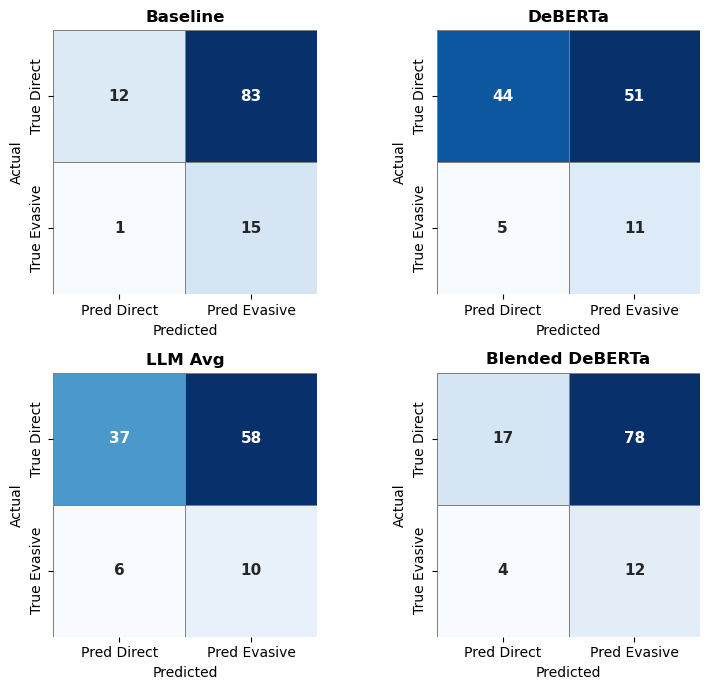

In [ ]:
# Generate confusion matrices.
models = ["Baseline", "DeBERTa", "LLM Avg", "Blended DeBERTa"]
fig, axes = plt.subplots(2, 2, figsize=(8,7))
for ax, name in zip(axes.ravel(), models):
    M = to_numeric_matrix(conf_matrices[name])
    df_cm = pd.DataFrame(M,
                         index=["True Direct", "True Evasive"],
                         columns=["Pred Direct", "Pred Evasive"])
    sns.heatmap(df_cm, ax=ax, annot=True, fmt="d", cmap="Blues", cbar=False,
                annot_kws={"size":11, "weight":"bold"},
                linewidths=0.4, linecolor="grey", square=True)
    ax.set_title(name, fontsize=12, weight="bold")
    ax.set_ylabel("Actual"); ax.set_xlabel("Predicted")
plt.tight_layout(); plt.show()

In [ ]:
# Function to determine precision at K (threshold free)
# 1) Ranks DeBERTa's evasion scores (highest to lowest)
# 2) Looks at the to 10%, 25% or 50% of rows
# 3) Reports what fraction are truly evasive.

def precision_at_k(df, score_col, label_col='label', k_percents=(10, 25, 50)):
    # Ground truth 1 = evasive
    y_true = (df[label_col].astype(str).str.strip().str.lower() == 'evasive').astype(int).values
    scores = df[score_col].astype(float).values

    # Sort by score (descending)
    order = np.argsort(-scores)
    y_sorted = y_true[order]

    n = len(y_true)
    results = {}
    for k in k_percents:
        top_k = max(1, int(np.ceil(n * k / 100)))
        results[f"P@{k}%"] = y_sorted[:top_k].mean()
    return results

# Precision at K.
p_deberta = precision_at_k(jpm_test_qa_scores, score_col='evasion_score_deberta')
print('DeBERTa:', p_deberta)

p_roberta = precision_at_k(jpm_test_qa_scores, score_col='evasion_score_roberta')
print('RoBERTa:', p_roberta)

p_llm_avg = precision_at_k(jpm_test_qa_scores, score_col='evasion_score_llm_avg')
print('llm_avg:', p_llm_avg)

p_blended = precision_at_k(jpm_test_qa_scores, score_col='evasion_score_blended_deberta')
print('Blended:', p_blended)

p_baseline = precision_at_k(jpm_test_qa_scores, score_col='evasion_score_baseline')
print('Baseline:', p_baseline)

DeBERTa: {'P@10%': 0.08333333333333333, 'P@25%': 0.14285714285714285, 'P@50%': 0.19642857142857142}
llm_avg: {'P@10%': 0.16666666666666666, 'P@25%': 0.17857142857142858, 'P@50%': 0.17857142857142858}
Blended: {'P@10%': 0.08333333333333333, 'P@25%': 0.17857142857142858, 'P@50%': 0.17857142857142858}
Baseline: {'P@10%': 0.0, 'P@25%': 0.10714285714285714, 'P@50%': 0.16071428571428573}
